In [4]:
import numpy
import pandas as pd
import os
import csv
import ast
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

from wquantiles import quantile
from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.examples.utils_example import (
    wavg,
    collapse,
    dataframe_by_group,
    graph_builder_bar,
    df_weighted_average_grouped)
from openfisca_france_indirect_taxation.build_survey_data.utils import weighted_sum
from openfisca_france_indirect_taxation.almost_ideal_demand_system.utils import add_niveau_vie_decile
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.calibration import get_inflators_by_year_energy
from openfisca_france_indirect_taxation.utils import assets_directory, get_input_data_frame

In [5]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.new_calage_bdf_cn import (
    new_get_bdf_aggregates,
    new_get_cn_aggregates,
    new_get_inflators_bdf_to_cn,
    new_get_inflators_cn_to_cn,
    new_get_inflators,
    new_get_inflators_by_year)

In [6]:
data_year = 2017
inflators_by_year = new_get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
simulated_variables = ['tva_taux_plein',
'tva_taux_intermediaire',
 'tva_taux_reduit',
 'tva_taux_super_reduit',
 'tva_total',
 'depenses_tva_exonere',
 'depenses_tva_taux_plein',
 'depenses_tva_taux_intermediaire',
 'depenses_tva_taux_reduit',
 'depenses_tva_taux_super_reduit',
 'rev_disponible',
 'rev_disp_yc_loyerimpute',
 'loyer_impute',
 'depenses_tot',
 'depenses_totales',
 'pondmen',
]

agregates = pd.DataFrame(columns = simulated_variables)
for year in range(2017,2025) :
    inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])
    survey_scenario = SurveyScenario.create(
        inflation_kwargs = inflation_kwargs,
        year = year,
        data_year = data_year
        )
    df_sum = dataframe_by_group(survey_scenario, category = 'niveau_vie_decile', variables = simulated_variables, aggfunc = 'sum')
    agregates.loc[year] = df_sum.sum()

In [5]:
agregates 

,tva_taux_plein,tva_taux_intermediaire,tva_taux_reduit,tva_taux_super_reduit,tva_total,depenses_tva_exonere,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,depenses_tot,depenses_totales,pondmen
2017,7.876044e+10,1.182956e+10,1.085693e+10,2.916588e+08,1.017386e+11,1.828582e+11,4.725627e+11,1.301252e+11,2.082556e+11,1.418017e+10,1.197964e+12,1.387077e+12,1.891127e+11,1.007982e+12,8.251237e+11,8.445859e+10
2018,8.112204e+10,1.241641e+10,1.108701e+10,2.906346e+08,1.049161e+11,1.907752e+11,4.867323e+11,1.365805e+11,2.126691e+11,1.413038e+10,1.234271e+12,1.426805e+12,1.925339e+11,1.040887e+12,8.501123e+11,8.445859e+10
2019,8.256655e+10,1.307885e+10,1.135869e+10,2.915240e+08,1.072956e+11,1.929483e+11,4.953993e+11,1.438674e+11,2.178804e+11,1.417362e+10,1.278664e+12,1.475381e+12,1.967170e+11,1.064269e+12,8.713206e+11,8.445859e+10
2020,7.678579e+10,9.625282e+09,1.092114e+10,2.828792e+08,9.761510e+10,1.906758e+11,4.607148e+11,1.058781e+11,2.094874e+11,1.375332e+10,1.289747e+12,1.489995e+12,2.002478e+11,9.805093e+11,7.898335e+11,8.445859e+10
2021,8.383946e+10,1.139929e+10,1.113713e+10,2.987876e+08,1.066747e+11,1.999309e+11,5.030368e+11,1.253922e+11,2.136304e+11,1.452677e+10,1.358404e+12,1.562187e+12,2.037834e+11,1.056517e+12,8.565861e+11,8.445859e+10
2022,8.862212e+10,1.542947e+10,1.227636e+10,3.059662e+08,1.166339e+11,2.136061e+11,5.317327e+11,1.697241e+11,2.354829e+11,1.487579e+10,1.434894e+12,1.642992e+12,2.080976e+11,1.165422e+12,9.518155e+11,8.445859e+10
2023,9.262292e+10,1.694231e+10,1.344158e+10,3.112216e+08,1.233180e+11,2.546692e+11,5.557376e+11,1.863654e+11,2.578338e+11,1.513130e+10,1.560302e+12,1.773999e+12,2.136968e+11,1.269737e+12,1.015068e+12,8.445859e+10
2024,9.528888e+10,1.742996e+10,1.382846e+10,3.201795e+08,1.268675e+11,2.619993e+11,5.717333e+11,1.917296e+11,2.652551e+11,1.556682e+10,1.605212e+12,1.825060e+12,2.198476e+11,1.306284e+12,1.044285e+12,8.445859e+10


In [6]:
agregates[['depenses_tva_taux_plein', 'depenses_tva_taux_intermediaire' , 'depenses_tva_taux_reduit','depenses_tva_taux_super_reduit','depenses_tva_exonere']]

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,depenses_tva_exonere
2017,4.725627e+11,1.301252e+11,2.082556e+11,1.418017e+10,1.828582e+11
2018,4.867323e+11,1.365805e+11,2.126691e+11,1.413038e+10,1.907752e+11
2019,4.953993e+11,1.438674e+11,2.178804e+11,1.417362e+10,1.929483e+11
2020,4.607148e+11,1.058781e+11,2.094874e+11,1.375332e+10,1.906758e+11
2021,5.030368e+11,1.253922e+11,2.136304e+11,1.452677e+10,1.999309e+11
2022,5.317327e+11,1.697241e+11,2.354829e+11,1.487579e+10,2.136061e+11
2023,5.557376e+11,1.863654e+11,2.578338e+11,1.513130e+10,2.546692e+11
2024,5.717333e+11,1.917296e+11,2.652551e+11,1.556682e+10,2.619993e+11


In [150]:
tva_cpo = pd.DataFrame(data = {'' : [2015,2016,2017,2018,2019,2020,2021] , 'tva (CPO)' : [152.6, 155.4, 162.9, 168.6, 174.9, 162.6, 185.9]})
tva_cpo.set_index('', inplace= True)

In [151]:
tva_cpo.loc[:,'tva (CPO)'] = tva_cpo.loc[:,'tva (CPO)'] * 1e9

In [176]:
compare_agregate = tva_cpo.merge(agregates['tva_total'], left_index = True, right_index = True)
compare_agregate.rename(columns={'tva_total' : 'tva (BdF)'}, inplace = True)
compare_agregate = (compare_agregate * 1e-9).round(1)
compare_agregate.loc[:,'ratio'] = (compare_agregate.loc[:,'tva (BdF)'] / compare_agregate.loc[:,'tva (CPO)'] * 100).round(2) 

In [177]:
compare_agregate

,tva (CPO),tva (BdF),ratio
2017,162.9,101.7,62.43
2018,168.6,104.9,62.22
2019,174.9,107.3,61.35
2020,162.6,97.6,60.02
2021,185.9,106.7,57.40


In [11]:
compare_agregate['growth rate (CPO)'] = compare_agregate['tva (CPO)'].pct_change()
compare_agregate['growth rate (BDF)'] = compare_agregate['tva (BdF)'].pct_change()
compare_agregate

,tva (CPO),tva (BdF),ratio,growth rate (CPO),growth rate (BDF)
2017,1.629000e+11,1.017386e+11,62.454632,NaN,NaN
2018,1.686000e+11,1.049161e+11,62.227821,0.034991,0.031232
2019,1.749000e+11,1.072956e+11,61.346835,0.037367,0.022680
2020,1.626000e+11,9.761510e+10,60.033885,-0.070326,-0.090223
2021,1.859000e+11,1.066747e+11,57.382824,0.143296,0.092809


In [161]:
tva_plf= pd.DataFrame(data = {'' : [2021,2022,2023,2024] , 'tva (PLF)' : [186.7,202.7,208.4,210.1]})
tva_plf.set_index('', inplace= True)
tva_plf.loc[:,'tva (PLF)'] = tva_plf.loc[:,'tva (PLF)'] * 1e9

In [170]:
compare_agregate_plf = tva_plf.merge(agregates['tva_total'], left_index = True, right_index = True)
compare_agregate_plf.rename(columns={'tva_total' : 'tva (BdF)'}, inplace = True)
compare_agregate_plf = compare_agregate_plf * 1e-9
compare_agregate_plf = compare_agregate_plf.round(1)
compare_agregate_plf.loc[:,'ratio'] = (compare_agregate_plf.loc[:,'tva (BdF)'] / compare_agregate_plf.loc[:,'tva (PLF)'] * 100).round(2) 

In [171]:
compare_agregate_plf

,tva (PLF),tva (BdF),ratio
2021,186.7,106.7,57.15
2022,202.7,116.6,57.52
2023,208.4,123.3,59.17
2024,210.1,126.9,60.40


## Le revenu disponible et les niveaux de vie

In [12]:
data_year = 2017 
survey_scenario_test = SurveyScenario.create(
    year = 2017,
    data_year = data_year
    )
test_revenus_2017= dataframe_by_group(survey_scenario_test, category = 'niveau_vie_decile', variables = simulated_variables, aggfunc = 'mean')

In [241]:
test_table_micro_2017 = survey_scenario_test.create_data_frame_by_entity(simulated_variables+['situapr','decile_rev_disponible','situacj'], period = 2017) 
test_menages_2017 = test_table_micro_2017['menage']

In [15]:
mean_by_rev_decile = df_weighted_average_grouped(dataframe = test_menages_2017[test_menages_2017['situapr'] != 3], groupe = 'decile_rev_disponible', varlist = simulated_variables + ['situapr'])

In [16]:
mean_by_rev_decile['rev_disponible']

decile_rev_disponible
1.0     10033.130723
2.0     15273.706832
3.0     19137.838248
4.0     22856.047215
5.0     27059.931346
6.0     31978.798300
7.0     37481.830879
8.0     44309.849606
9.0     53473.676828
10.0    84027.880214
Name: rev_disponible, dtype: float64

In [ ]:
data_year = 2017
inflators_by_year = new_get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
simulated_variables = ['rev_disponible',
 'rev_disp_yc_loyerimpute',
 'loyer_impute',
 'niveau_de_vie',
 'ocde10',
 'depenses_tot',
 'depenses_totales',
 'pondmen',
]

inflation_kwargs = dict(inflator_by_variable = inflators_by_year[2018])
survey_scenario = SurveyScenario.create(
    inflation_kwargs = inflation_kwargs,
    year = 2018,
    data_year = data_year
    )

In [ ]:
revenus_mean_2018 = dataframe_by_group(survey_scenario, category = 'niveau_vie_decile', variables = simulated_variables, aggfunc = 'mean')

In [18]:
revenus_mean_2018

,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,niveau_de_vie,ocde10,depenses_tot,depenses_totales,pondmen
niveau_vie_decile,,,,,,,,
1.0,15041.670428,18536.660355,3632.937147,9714.736426,1.505482,22099.307421,17114.574805,1.0
2.0,23506.066256,27219.807778,3719.387471,15289.942116,1.539022,24670.345784,19524.990365,1.0
3.0,27594.978323,31998.140183,4415.003312,18437.628800,1.495870,26585.642253,20708.957141,1.0
4.0,32223.904223,37562.447981,5376.003594,21276.547155,1.515424,30198.695606,23639.259226,1.0
5.0,35947.667202,41773.157343,5851.669616,23897.229821,1.504028,32646.835122,26155.870711,1.0
6.0,40597.777514,47262.755976,6704.862703,26660.633355,1.522874,37198.963601,30326.362086,1.0
7.0,46436.936627,53814.823807,7393.998517,29753.419533,1.561009,38738.099003,31503.920182,1.0
8.0,52750.525082,61048.592109,8306.410044,33848.909800,1.558936,44163.893889,36821.297226,1.0
9.0,62655.749144,72314.424510,9644.858803,40073.036461,1.564487,47112.961284,39600.470852,1.0


In [ ]:
revenus_mean_2018_by_rev_decile = dataframe_by_group(survey_scenario, category = 'decile_rev_disponible', variables = simulated_variables, aggfunc = 'mean')

In [188]:
revenus_mean_2018_by_rev_decile

,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,niveau_de_vie,ocde10,depenses_tot,depenses_totales,pondmen
decile_rev_disponible,,,,,,,,
1.0,11944.401586,15042.466632,3246.367145,10869.768299,1.110917,18053.312132,13467.546769,1.0
2.0,19117.531415,22470.840079,3397.882755,17274.962335,1.164003,20002.008871,14911.649411,1.0
3.0,23962.092481,27925.397362,3990.379483,21024.704420,1.205091,22456.507801,17021.721805,1.0
4.0,28615.130123,33572.464616,5016.619059,22993.612721,1.350724,26566.070160,20834.701029,1.0
5.0,33868.564354,39641.709568,5831.988255,24988.542020,1.477162,32240.807718,25588.329713,1.0
6.0,40030.734783,46557.044494,6560.163233,27228.797496,1.591578,36893.351064,30019.128321,1.0
7.0,46923.225209,54298.538753,7382.005670,29413.567715,1.722166,40075.024431,32916.533923,1.0
8.0,55473.455328,63871.329109,8367.191966,32667.675345,1.809757,43740.489127,36184.611676,1.0
9.0,66943.999751,76972.847431,9979.151314,37615.207938,1.898974,54401.498830,46554.783987,1.0


In [8]:
table_micro = survey_scenario.create_data_frame_by_entity(
    ['rev_disponible',
 'rev_disp_yc_loyerimpute',
 'loyer_impute',
 'niveau_de_vie',
 'niveau_vie_decile',
 'decile_rev_disponible',
 'ocde10',
 'depenses_tot',
 'depenses_totales',
 'pondmen',
 'situapr'
], 
    period = 2018) 
menages = table_micro['menage']

Y a-t-il des ménages dont le responsable est étudiant ? (situapr == 3)

In [9]:
len(menages[menages['situapr'] == 3])

155

Y a-t-il des ménages dont le revenu disponible est négatif ou nul ?

In [10]:
len(menages[menages['rev_disponible'] <= 0])

33

### Revenu disponible par décile

In [15]:
mean_by_rev_decile = df_weighted_average_grouped(dataframe =  menages[(menages['situapr'] != 3) & (menages['rev_disponible'] > 0)], groupe = 'decile_rev_disponible', varlist = simulated_variables)
mean_by_rev_decile

,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,niveau_de_vie,ocde10,depenses_tot,depenses_totales,pondmen
decile_rev_disponible,,,,,,,,
1,12987.979566,16366.880374,3541.380066,11757.238633,1.113055,17632.506422,13270.444859,3261.056790
2,19121.240294,22496.640700,3422.558174,17277.793512,1.164250,19867.047620,14806.859805,3435.593055
3,23958.768360,27965.713739,4039.323360,21010.080229,1.206099,22354.334904,16962.417717,3152.556469
4,28613.615324,33587.186062,5034.833613,22989.354018,1.350951,26588.272672,20857.055249,3072.621848
5,33876.481762,39684.799959,5871.237103,24973.946401,1.478361,32270.408356,25614.682491,2911.774035
6,40034.439226,46578.493095,6579.969017,27229.484736,1.591450,36938.752260,30053.215434,2819.474450
7,46923.716934,54293.860456,7376.205530,29430.415240,1.720890,40101.702356,32937.641620,2707.920285
8,55471.752452,63871.228567,8369.018641,32671.917791,1.809453,43741.226291,36182.717145,2776.187860
9,66943.999751,76972.847431,9979.151314,37615.207938,1.898974,54401.498830,46554.783987,2735.426580


In [25]:
revenus_mean_2018_by_rev_decile

,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,niveau_de_vie,ocde10,depenses_tot,depenses_totales,pondmen
decile_rev_disponible,,,,,,,,
1.0,11944.401586,15042.466632,3246.367145,10869.768299,1.110917,18053.312132,13467.546769,1.0
2.0,19117.531415,22470.840079,3397.882755,17274.962335,1.164003,20002.008871,14911.649411,1.0
3.0,23962.092481,27925.397362,3990.379483,21024.704420,1.205091,22456.507801,17021.721805,1.0
4.0,28615.130123,33572.464616,5016.619059,22993.612721,1.350724,26566.070160,20834.701029,1.0
5.0,33868.564354,39641.709568,5831.988255,24988.542020,1.477162,32240.807718,25588.329713,1.0
6.0,40030.734783,46557.044494,6560.163233,27228.797496,1.591578,36893.351064,30019.128321,1.0
7.0,46923.225209,54298.538753,7382.005670,29413.567715,1.722166,40075.024431,32916.533923,1.0
8.0,55473.455328,63871.329109,8367.191966,32667.675345,1.809757,43740.489127,36184.611676,1.0
9.0,66943.999751,76972.847431,9979.151314,37615.207938,1.898974,54401.498830,46554.783987,1.0


### Niveaux de vie par décile

In [26]:
df_weighted_average_grouped(dataframe= menages, groupe = 'niveau_vie_decile', varlist = simulated_variables)

,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,niveau_de_vie,ocde10,depenses_tot,depenses_totales,pondmen
niveau_vie_decile,,,,,,,,
1.0,15041.670428,18536.660355,3632.937147,9714.736426,1.505482,22099.307421,17114.574805,3235.018224
2.0,23506.066256,27219.807778,3719.387471,15289.942116,1.539022,24670.345784,19524.990365,2978.797575
3.0,27594.978323,31998.140183,4415.003312,18437.628800,1.495870,26585.642253,20708.957141,2961.258047
4.0,32223.904223,37562.447981,5376.003594,21276.547155,1.515424,30198.695606,23639.259226,2981.246824
5.0,35947.667202,41773.157343,5851.669616,23897.229821,1.504028,32646.835122,26155.870711,2919.165090
6.0,40597.777514,47262.755976,6704.862703,26660.633355,1.522874,37198.963601,30326.362086,2873.985821
7.0,46436.936627,53814.823807,7393.998517,29753.419533,1.561009,38738.099003,31503.920182,3006.863986
8.0,52750.525082,61048.592109,8306.410044,33848.909800,1.558936,44163.893889,36821.297226,2981.366136
9.0,62655.749144,72314.424510,9644.858803,40073.036461,1.564487,47112.961284,39600.470852,2832.241422


In [27]:
revenus_mean_2018

,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,niveau_de_vie,ocde10,depenses_tot,depenses_totales,pondmen
niveau_vie_decile,,,,,,,,
1.0,15041.670428,18536.660355,3632.937147,9714.736426,1.505482,22099.307421,17114.574805,1.0
2.0,23506.066256,27219.807778,3719.387471,15289.942116,1.539022,24670.345784,19524.990365,1.0
3.0,27594.978323,31998.140183,4415.003312,18437.628800,1.495870,26585.642253,20708.957141,1.0
4.0,32223.904223,37562.447981,5376.003594,21276.547155,1.515424,30198.695606,23639.259226,1.0
5.0,35947.667202,41773.157343,5851.669616,23897.229821,1.504028,32646.835122,26155.870711,1.0
6.0,40597.777514,47262.755976,6704.862703,26660.633355,1.522874,37198.963601,30326.362086,1.0
7.0,46436.936627,53814.823807,7393.998517,29753.419533,1.561009,38738.099003,31503.920182,1.0
8.0,52750.525082,61048.592109,8306.410044,33848.909800,1.558936,44163.893889,36821.297226,1.0
9.0,62655.749144,72314.424510,9644.858803,40073.036461,1.564487,47112.961284,39600.470852,1.0


## Structure de la consommation par type de taux de TVA, par décile de niveau de vie

In [28]:
simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
'loyer_impute',
'tva_taux_plein',
 'tva_taux_intermediaire',
 'tva_taux_reduit',
 'tva_taux_super_reduit',
 'tva_total',
 'niveau_de_vie',
 'rev_disponible',
 'decile_rev_disponible',
 'rev_disp_yc_loyerimpute',
 'depenses_tot',
 'pondmen'] + ["poste_agrege_0{}".format(i) for i in range(1, 10)] + ["poste_agrege_{}".format(i) for i in range(10, 14)] + ['poste_04_1_1_1',
 'poste_04_1_2_1',
 'poste_04_3_1_1',
 'poste_04_3_2_1',
 'poste_04_4_1_1',
 'poste_04_4_2_1',
 'poste_04_4_3_1',
 'poste_04_4_4_1',
 'poste_04_5_0_0',
 'poste_04_5_1_1',
 'poste_04_5_2_1',
 'poste_04_5_2_2',
 'poste_04_5_3_1',
 'poste_04_5_4_1',
 'poste_04_5_5_1',
 'poste_04_5_5_2',
 'poste_04_6_1_1']

In [29]:
inflators_by_year = new_get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[2017])
survey_scenario = SurveyScenario.create(
    inflation_kwargs = inflation_kwargs,
    year = 2017,
    data_year = data_year
    )
to_graph = dataframe_by_group(survey_scenario, category = 'niveau_vie_decile', variables = simulated_variables, aggfunc = 'mean')
to_graph['poste_agrege_12'] += to_graph['poste_agrege_13']
to_graph.drop('poste_agrege_13', axis = 1, inplace = True)

table_micro_2017 = survey_scenario.create_data_frame_by_entity(simulated_variables, period = 2017) 
menages_2017 = table_micro_2017['menage']

### La non-réponse dans l'enquête Budget de famille (2017)

In [30]:
len(menages_2017)

12081

In [31]:
liste_postes_agreges = ["poste_agrege_0{}".format(i) for i in range(1, 10)] + ["poste_agrege_{}".format(i) for i in range(10, 13)]

In [32]:
{ key : dict((menages_2017== 0).sum())[key] for key in liste_postes_agreges}

{'poste_agrege_01': 592,
 'poste_agrege_02': 6012,
 'poste_agrege_03': 1889,
 'poste_agrege_04': 63,
 'poste_agrege_05': 1768,
 'poste_agrege_06': 1846,
 'poste_agrege_07': 2004,
 'poste_agrege_08': 147,
 'poste_agrege_09': 251,
 'poste_agrege_10': 10496,
 'poste_agrege_11': 3938,
 'poste_agrege_12': 18}

In [33]:
menages_2017.loc[menages_2017['depenses_tot'] > menages_2017['rev_disponible'], ['depenses_tot','rev_disponible'] + liste_postes_agreges ]

,depenses_tot,rev_disponible,poste_agrege_01,poste_agrege_02,poste_agrege_03,poste_agrege_04,poste_agrege_05,poste_agrege_06,poste_agrege_07,poste_agrege_08,poste_agrege_09,poste_agrege_10,poste_agrege_11,poste_agrege_12
8,32109.376953,28550.265625,5063.651367,1115.066162,3497.984375,5238.787109,179.294220,1804.769043,2425.657227,539.984985,9366.306641,0.0,356.567963,1443.966797
9,36032.285156,30670.318359,3906.492188,3622.417969,1829.361206,1297.839478,0.000000,3709.919922,5096.124512,1042.039673,1302.225586,0.0,2668.527832,686.152466
10,19799.042969,18533.613281,2555.218506,0.000000,0.000000,5429.945312,74.083122,14.818657,0.000000,423.068146,0.000000,0.0,10669.509766,374.230896
11,45560.093750,27246.222656,6847.936035,0.000000,4561.796387,4397.083008,3983.191895,966.075195,15874.896484,852.596924,5107.301270,0.0,0.000000,1565.168701
14,19113.314453,15934.557617,2985.033691,5983.040527,463.946747,3683.850098,1079.065674,2111.519775,0.000000,208.407944,83.361824,0.0,0.000000,940.414001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12068,37109.742188,7513.264648,10304.792969,1022.300293,1654.708130,11235.880859,551.373291,590.175293,5470.275879,1928.175903,1176.174561,0.0,0.000000,1781.953003
12070,25565.953125,22100.359375,3266.656006,1137.164062,374.316040,8831.885742,0.000000,2904.837402,3056.261719,937.835754,163.701462,0.0,2130.996094,1424.149414
12073,85041.390625,68879.234375,11681.289062,0.000000,6460.793457,2455.833008,-234.369354,18111.683594,1708.185547,4151.328125,15422.102539,0.0,792.373291,1804.141724
12074,55453.644531,15413.289062,6059.100586,5279.975098,0.000000,2199.064697,3404.153809,727.285339,4734.723633,1646.422729,1400.923096,0.0,0.000000,29346.716797


In [35]:
test = menages_2017.loc[menages_2017['poste_04_3_2_1'] > 0, ['poste_04_3_2_1','rev_disponible','decile_rev_disponible']]

In [36]:
test.sort_values(by = 'poste_04_3_2_1', ascending = False)

,poste_04_3_2_1,rev_disponible,decile_rev_disponible
3564,956396.937500,37511.277344,6
3833,692671.187500,46474.011719,7
10674,643258.500000,39957.902344,6
10210,469228.843750,33496.230469,5
6063,464179.062500,34139.429688,5
...,...,...,...
3636,16464.505859,133464.250000,10
2150,12665.987305,31818.324219,5
5946,10182.585938,34466.835938,5
6045,9678.244141,48347.421875,7


In [38]:
test.loc[test['decile_rev_disponible'] == 6,'poste_04_3_2_1'].describe()

count         8.000000
mean     272840.625000
std      339473.000000
min       19152.197266
25%       86958.958984
50%       97347.433594
75%      310919.976562
max      956396.937500
Name: poste_04_3_2_1, dtype: float64

In [39]:
test.loc[test['decile_rev_disponible'] == 7,'poste_04_3_2_1'].describe()

count         9.000000
mean     150666.062500
std      211778.656250
min        9678.244141
25%       60591.167969
50%       66343.210938
75%      155132.796875
max      692671.187500
Name: poste_04_3_2_1, dtype: float64

In [40]:
test.loc[test['decile_rev_disponible'] == 9,'poste_04_3_2_1'].describe()

count        13.000000
mean     119749.867188
std       86463.984375
min        9671.859375
25%       64479.066406
50%       99578.664062
75%      146833.515625
max      317179.562500
Name: poste_04_3_2_1, dtype: float64

### Structure de la consommation par poste agrégé

In [41]:
label_postes_agreges = ['Alimentation', 'Alcools et tabacs', 'Habillement et chaussures', 'Logement', 'Ameublement et équipement ménager', 'Santé',
                        'Transports', 'Communication' , 'Loisirs et cultures' , 'Education', 'Restauration et hôtellerie', 'Services et biens divers']
liste_postes_agreges = ["poste_agrege_0{}".format(i) for i in range(1, 10)] + ["poste_agrege_{}".format(i) for i in range(10, 13)]

In [42]:
to_graph

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,depenses_tva_exonere,depenses_totales,loyer_impute,tva_taux_plein,tva_taux_intermediaire,tva_taux_reduit,...,poste_04_4_4_1,poste_04_5_0_0,poste_04_5_1_1,poste_04_5_2_1,poste_04_5_2_2,poste_04_5_3_1,poste_04_5_4_1,poste_04_5_5_1,poste_04_5_5_2,poste_04_6_1_1
niveau_vie_decile,,,,,,,,,,,,,,,,,,,,,
1.0,9804.913574,2138.376299,4473.642436,213.106678,4796.299563,16630.039005,3568.381437,1634.152221,194.397844,233.223075,...,174.211737,0.0,748.821318,240.468909,40.067364,72.433489,54.428752,53.613426,0.000000,0.0
2.0,11114.674165,2178.221855,5317.116330,355.685947,4928.570313,18965.698274,3653.295564,1852.445651,198.020167,277.195651,...,191.000594,0.0,787.313254,293.149621,48.909271,99.475437,73.551009,27.536447,0.000000,0.0
3.0,12177.185009,2355.781147,5258.511232,329.502806,5627.496026,20120.980171,4336.550635,2029.530787,214.161921,274.140408,...,168.796585,0.0,804.450904,323.802879,61.912705,97.988729,86.285028,23.589282,0.000000,0.0
4.0,13608.198738,2689.378526,6225.095568,411.037020,6262.666984,22933.709856,5280.474352,2268.033075,244.488956,324.531063,...,153.728166,0.0,864.879421,327.279199,59.539329,135.033468,86.226738,217.165739,18.544286,0.0
5.0,14758.046986,3852.543933,6257.155767,471.302380,6203.771377,25339.049052,5747.687996,2459.674445,350.231264,326.202448,...,136.583090,0.0,879.556499,320.735680,57.118193,119.504298,97.200907,0.000000,17.984981,0.0
6.0,16252.904780,5688.880045,6982.075648,510.616813,6595.387329,29434.477227,6585.720201,2708.817403,517.170916,363.994482,...,168.021964,0.0,937.064753,331.608857,48.329083,112.793320,99.517380,44.347191,17.246770,0.0
7.0,17888.262952,4526.259537,7687.757651,480.795612,6933.474765,30583.075776,7262.610366,2981.377088,411.478139,400.783592,...,151.820355,0.0,992.581975,378.725528,49.067604,110.006070,98.679010,0.000000,36.749768,0.0
8.0,20493.341967,5870.983502,8810.869277,585.533653,7032.353779,35760.728391,8158.808756,3415.556917,533.725771,459.334437,...,173.724527,0.0,989.338783,362.383509,52.201572,121.619960,91.298057,92.685536,22.153642,0.0
9.0,21960.702479,5981.983352,9721.768306,762.031701,7212.981596,38426.485815,9473.473873,3660.117002,543.816666,506.822065,...,196.761419,0.0,1090.857344,425.411742,36.911233,87.996634,98.207916,53.099599,0.000000,0.0


In [43]:
for poste in liste_postes_agreges:
    to_graph['Part poste {}'.format(poste[-2:])] = to_graph[poste] / to_graph['depenses_tot']

In [135]:
to_graph.index = to_graph.index.astype(int)

In [136]:
to_graph

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,depenses_tva_exonere,depenses_totales,loyer_impute,tva_taux_plein,tva_taux_intermediaire,tva_taux_reduit,...,Part poste 10,Part poste 11,Part poste 12,loyers,part loyer,Part TVA exonere,Part TVA taux super réduit,Part TVA taux réduit,Part TVA taux intermédiaire,Part TVA taux plein
niveau_vie_decile,,,,,,,,,,,,,,,,,,,,,
1,9804.913574,2138.376299,4473.642436,213.106678,4796.299563,16630.039005,3568.381437,1634.152221,194.397844,233.223075,...,0.023569,0.060375,0.123470,5493.046855,0.256369,0.223851,0.012815,0.269010,0.128585,0.589591
2,11114.674165,2178.221855,5317.116330,355.685947,4928.570313,18965.698274,3653.295564,1852.445651,198.020167,277.195651,...,0.009577,0.058738,0.130468,5616.454906,0.235054,0.206266,0.018754,0.280354,0.114851,0.586041
3,12177.185009,2355.781147,5258.511232,329.502806,5627.496026,20120.980171,4336.550635,2029.530787,214.161921,274.140408,...,0.006688,0.058639,0.148035,6506.121894,0.252680,0.218556,0.016376,0.261345,0.117081,0.605198
4,13608.198738,2689.378526,6225.095568,411.037020,6262.666984,22933.709856,5280.474352,2268.033075,244.488956,324.531063,...,0.006202,0.070510,0.143788,7500.943773,0.256914,0.214502,0.017923,0.271439,0.117267,0.593371
5,14758.046986,3852.543933,6257.155767,471.302380,6203.771377,25339.049052,5747.687996,2459.674445,350.231264,326.202448,...,0.006021,0.075765,0.141644,7972.083480,0.252738,0.196678,0.018600,0.246937,0.152040,0.582423
6,16252.904780,5688.880045,6982.075648,510.616813,6595.387329,29434.477227,6585.720201,2708.817403,517.170916,363.994482,...,0.006426,0.071967,0.140727,8760.677759,0.243150,0.183053,0.017348,0.237207,0.193273,0.552172
7,17888.262952,4526.259537,7687.757651,480.795612,6933.474765,30583.075776,7262.610366,2981.377088,411.478139,400.783592,...,0.006171,0.077568,0.153638,9261.827868,0.246873,0.184811,0.015721,0.251373,0.147999,0.584907
8,20493.341967,5870.983502,8810.869277,585.533653,7032.353779,35760.728391,8158.808756,3415.556917,533.725771,459.334437,...,0.006905,0.081140,0.165241,10154.238233,0.237287,0.164334,0.016374,0.246384,0.164174,0.573068
9,21960.702479,5981.983352,9721.768306,762.031701,7212.981596,38426.485815,9473.473873,3660.117002,543.816666,506.822065,...,0.007965,0.099293,0.153721,11335.576525,0.248372,0.158043,0.019831,0.252997,0.155673,0.571499


In [63]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import stacked_bar_plot

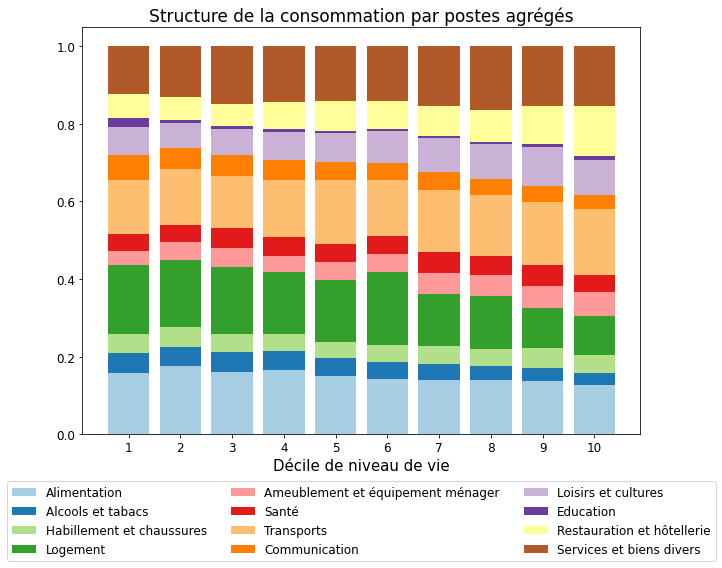

In [137]:
stacked_bar_plot(to_graph, 
                 variables = ["Part poste 0{}".format(i) for i in range(1, 10)] + ["Part poste {}".format(i) for i in range(10, 13)],
                 labels = label_postes_agreges,
                 title = 'Structure de la consommation par postes agrégés',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel = '',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Structure_conso_postes_agreges.pdf')

In [47]:
to_graph[['poste_04_1_1_1',
 'poste_04_1_2_1',
 'loyer_impute',
 'poste_04_3_1_1',
 'poste_04_3_2_1',
 'poste_04_4_1_1',
 'poste_04_4_2_1',
 'poste_04_4_3_1',
 'poste_04_4_4_1',
 'poste_04_5_0_0',
 'poste_04_5_1_1',
 'poste_04_5_2_1',
 'poste_04_5_2_2',
 'poste_04_5_3_1',
 'poste_04_5_4_1',
 'poste_04_5_5_1',
 'poste_04_5_5_2',
 'poste_04_6_1_1', 
 'depenses_tot']]

,poste_04_1_1_1,poste_04_1_2_1,loyer_impute,poste_04_3_1_1,poste_04_3_2_1,poste_04_4_1_1,poste_04_4_2_1,poste_04_4_3_1,poste_04_4_4_1,poste_04_5_0_0,poste_04_5_1_1,poste_04_5_2_1,poste_04_5_2_2,poste_04_5_3_1,poste_04_5_4_1,poste_04_5_5_1,poste_04_5_5_2,poste_04_6_1_1,depenses_tot
niveau_vie_decile,,,,,,,,,,,,,,,,,,,
1.0,1907.937079,16.728339,3568.381437,28.920145,320.558837,109.632986,35.317884,0.0,174.211737,0.0,748.821318,240.468909,40.067364,72.433489,54.428752,53.613426,0.000000,0.0,21426.338557
2.0,1950.465484,12.693858,3653.295564,40.462233,96.679934,130.983522,342.044849,0.0,191.000594,0.0,787.313254,293.149621,48.909271,99.475437,73.551009,27.536447,0.000000,0.0,23894.268637
3.0,2159.462762,10.108496,4336.550635,45.548174,275.582831,134.563086,263.041454,0.0,168.796585,0.0,804.450904,323.802879,61.912705,97.988729,86.285028,23.589282,0.000000,0.0,25748.476216
4.0,2197.179932,23.289489,5280.474352,64.266287,102.320054,147.339079,213.331365,0.0,153.728166,0.0,864.879421,327.279199,59.539329,135.033468,86.226738,217.165739,18.544286,0.0,29196.376843
5.0,2203.446030,20.949455,5747.687996,76.957131,957.457010,150.803288,55.593569,0.0,136.583090,0.0,879.556499,320.735680,57.118193,119.504298,97.200907,0.000000,17.984981,0.0,31542.820400
6.0,2150.324103,24.633456,6585.720201,71.820299,2599.230955,163.878302,23.957663,0.0,168.021964,0.0,937.064753,331.608857,48.329083,112.793320,99.517380,44.347191,17.246770,0.0,36029.864614
7.0,1954.227856,44.989647,7262.610366,206.448839,731.108669,161.119869,135.219853,0.0,151.820355,0.0,992.581975,378.725528,49.067604,110.006070,98.679010,0.000000,36.749768,0.0,37516.550538
8.0,1969.173079,26.256398,8158.808756,94.538358,1392.984727,171.574635,297.104017,0.0,173.724527,0.0,989.338783,362.383509,52.201572,121.619960,91.298057,92.685536,22.153642,0.0,42793.082280
9.0,1823.483854,38.618799,9473.473873,110.227168,465.367370,177.282944,55.315292,0.0,196.761419,0.0,1090.857344,425.411742,36.911233,87.996634,98.207916,53.099599,0.000000,0.0,45639.467491


In [138]:
to_graph['loyers'] = to_graph['poste_04_1_1_1'] + to_graph['poste_04_1_2_1'] + to_graph['loyer_impute']
to_graph['part loyer'] = to_graph['loyers'] / to_graph['depenses_tot']
to_graph[['loyers', 'depenses_tot', 'part loyer']]

,loyers,depenses_tot,part loyer
niveau_vie_decile,,,
1,5493.046855,21426.338557,0.256369
2,5616.454906,23894.268637,0.235054
3,6506.121894,25748.476216,0.252680
4,7500.943773,29196.376843,0.256914
5,7972.083480,31542.820400,0.252738
6,8760.677759,36029.864614,0.243150
7,9261.827868,37516.550538,0.246873
8,10154.238233,42793.082280,0.237287
9,11335.576525,45639.467491,0.248372


### Structure de la consommation par taux de TVA 

In [49]:
to_graph[['depenses_tva_taux_plein' , 'depenses_tva_taux_intermediaire', 'depenses_tva_taux_reduit','depenses_tva_taux_super_reduit','depenses_tva_exonere','depenses_tot']]

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,depenses_tva_exonere,depenses_tot
niveau_vie_decile,,,,,,
1.0,9804.913574,2138.376299,4473.642436,213.106678,4796.299563,21426.338557
2.0,11114.674165,2178.221855,5317.116330,355.685947,4928.570313,23894.268637
3.0,12177.185009,2355.781147,5258.511232,329.502806,5627.496026,25748.476216
4.0,13608.198738,2689.378526,6225.095568,411.037020,6262.666984,29196.376843
5.0,14758.046986,3852.543933,6257.155767,471.302380,6203.771377,31542.820400
6.0,16252.904780,5688.880045,6982.075648,510.616813,6595.387329,36029.864614
7.0,17888.262952,4526.259537,7687.757651,480.795612,6933.474765,37516.550538
8.0,20493.341967,5870.983502,8810.869277,585.533653,7032.353779,42793.082280
9.0,21960.702479,5981.983352,9721.768306,762.031701,7212.981596,45639.467491


In [139]:
to_graph.loc[:,'Part TVA exonere'] = to_graph['depenses_tva_exonere'] / to_graph['depenses_tot']
to_graph.loc[:,'Part TVA taux super réduit'] = to_graph['depenses_tva_taux_super_reduit'] / to_graph['depenses_tot']
to_graph.loc[:,'Part TVA taux réduit'] = to_graph['depenses_tva_taux_reduit'] / to_graph['depenses_tot']
to_graph.loc[:,'Part TVA taux intermédiaire'] = to_graph['depenses_tva_taux_intermediaire'] / to_graph['depenses_tot']
to_graph.loc[:,'Part TVA taux plein'] = to_graph['depenses_tva_taux_plein'] / to_graph['depenses_tot']

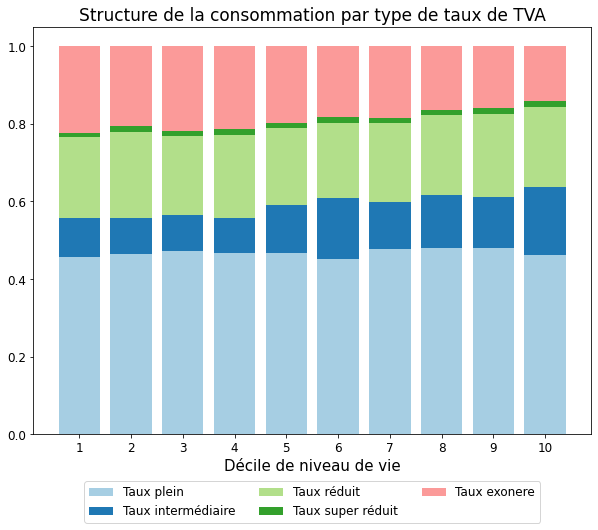

In [140]:
stacked_bar_plot(to_graph, 
                 variables = ['Part TVA taux plein','Part TVA taux intermédiaire','Part TVA taux réduit','Part TVA taux super réduit','Part TVA exonere'],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit','Taux exonere'],
                 title = 'Structure de la consommation par type de taux de TVA',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Structure_conso_taux_tva_avec_exo.pdf')

In [141]:
to_graph.loc[:,'Part TVA taux super réduit'] = to_graph['depenses_tva_taux_super_reduit'] / to_graph['depenses_totales']
to_graph.loc[:,'Part TVA taux réduit'] = to_graph['depenses_tva_taux_reduit'] / to_graph['depenses_totales']
to_graph.loc[:,'Part TVA taux intermédiaire'] = to_graph['depenses_tva_taux_intermediaire'] / to_graph['depenses_totales']
to_graph.loc[:,'Part TVA taux plein'] = to_graph['depenses_tva_taux_plein'] / to_graph['depenses_totales']

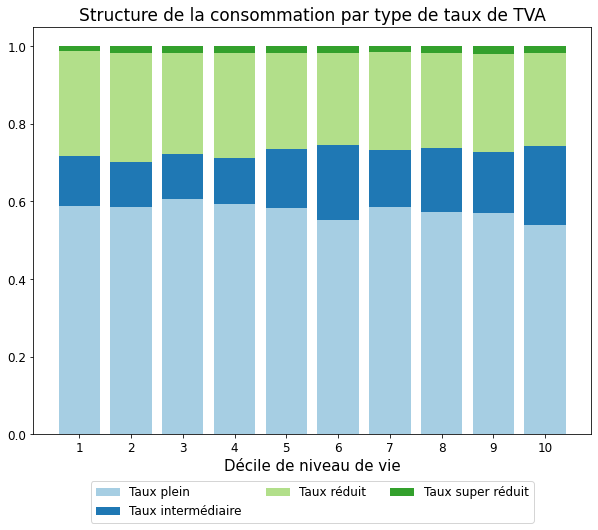

In [142]:
stacked_bar_plot(to_graph, 
                 variables = ['Part TVA taux plein','Part TVA taux intermédiaire','Part TVA taux réduit','Part TVA taux super réduit'],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Structure de la consommation par type de taux de TVA',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Structure_conso_taux_tva.pdf')

In [54]:
total_graph = pd.DataFrame(to_graph[['depenses_tva_taux_plein' , 'depenses_tva_taux_intermediaire', 
          'depenses_tva_taux_reduit','depenses_tva_taux_super_reduit',
          'depenses_tva_exonere','depenses_tot', 'depenses_totales']].mean()).T

In [55]:
total_graph.loc[:,'Part TVA exonere'] = total_graph['depenses_tva_exonere'] / total_graph['depenses_tot']
total_graph.loc[:,'Part TVA taux super réduit'] = total_graph['depenses_tva_taux_super_reduit'] / total_graph['depenses_tot']
total_graph.loc[:,'Part TVA taux réduit'] = total_graph['depenses_tva_taux_reduit'] / total_graph['depenses_tot']
total_graph.loc[:,'Part TVA taux intermédiaire'] = total_graph['depenses_tva_taux_intermediaire'] / total_graph['depenses_tot']
total_graph.loc[:,'Part TVA taux plein'] = total_graph['depenses_tva_taux_plein'] / total_graph['depenses_tot']

In [56]:
total_graph[['Part TVA exonere','Part TVA taux super réduit','Part TVA taux réduit','Part TVA taux intermédiaire','Part TVA taux plein']]

,Part TVA exonere,Part TVA taux super réduit,Part TVA taux réduit,Part TVA taux intermédiaire,Part TVA taux plein
0,0.181402,0.014068,0.206607,0.129101,0.468822


In [57]:
total_graph.loc[:,'Part TVA taux super réduit'] = total_graph['depenses_tva_taux_super_reduit'] / total_graph['depenses_totales']
total_graph.loc[:,'Part TVA taux réduit'] = total_graph['depenses_tva_taux_reduit'] / total_graph['depenses_totales']
total_graph.loc[:,'Part TVA taux intermédiaire'] = total_graph['depenses_tva_taux_intermediaire'] / total_graph['depenses_totales']
total_graph.loc[:,'Part TVA taux plein'] = total_graph['depenses_tva_taux_plein'] / total_graph['depenses_totales']

In [58]:
total_graph[['Part TVA taux super réduit','Part TVA taux réduit','Part TVA taux intermédiaire','Part TVA taux plein']]

,Part TVA taux super réduit,Part TVA taux réduit,Part TVA taux intermédiaire,Part TVA taux plein
0,0.017186,0.252391,0.15771,0.572714


## Réforme TVA

In [19]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Reform_TVA_budget_2025 import augmente_tous_les_taux

In [16]:
simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
'loyer_impute',
'depenses_ht_tva_taux_plein',
'tva_taux_plein',
 'tva_taux_intermediaire',
 'tva_taux_reduit',
 'tva_taux_super_reduit',
 'tva_total',
 'niveau_de_vie',
 'rev_disponible',
 'decile_rev_disponible',
 'rev_disp_yc_loyerimpute',
 'depenses_tot',
 'pondmen']

In [17]:
year = 2024
data_year = 2017
inflators_by_year = new_get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
tax_benefit_system = FranceIndirectTaxationTaxBenefitSystem()
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])

In [20]:
survey_scenario = SurveyScenario.create(
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux,
    year = year,
    data_year = data_year
    )

reforme_all = dataframe_by_group(survey_scenario, category = 'niveau_vie_decile', difference = True, 
                                 variables = ['depenses_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']],
                                 aggfunc = 'mean')
rev_disponible_2024 = dataframe_by_group(survey_scenario, category = 'niveau_vie_decile', use_baseline= True, variables = ['niveau_de_vie'], aggfunc = 'mean')

In [ ]:
reforme_all = reforme_all.merge(rev_disponible_2024, how = 'left', right_index = True, left_index = True)

In [38]:
recolte_taux_plein = survey_scenario.compute_aggregate(variable='tva_taux_plein',difference= True, period = year) * 1e-9
recolte_taux_inter = survey_scenario.compute_aggregate(variable='tva_taux_intermediaire',difference= True, period = year) * 1e-9
recolte_taux_reduit = survey_scenario.compute_aggregate(variable='tva_taux_reduit',difference= True, period = year) * 1e-9
recolte_taux_super_reduit = survey_scenario.compute_aggregate(variable='tva_taux_super_reduit',difference= True, period = year) * 1e-9

In [39]:
recolte_taux_plein + recolte_taux_inter + recolte_taux_reduit + recolte_taux_super_reduit

9.174167117535903

In [59]:
reforme_all

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,niveau_de_vie
niveau_vie_decile,,,,,,,,,
1.0,99.534226,28.264637,54.510254,2.350097,0.508809,0.144486,0.278651,0.012013,12634.352676
2.0,112.640972,28.709574,64.511316,3.837130,0.368463,0.093913,0.211025,0.012552,19885.101626
3.0,123.122252,31.406834,63.424170,3.498886,0.343071,0.087513,0.176727,0.009749,23978.777674
4.0,138.149037,36.465156,75.174762,4.357793,0.329646,0.087012,0.179379,0.010398,27670.889724
5.0,149.709990,51.786880,75.394226,5.011747,0.320227,0.110771,0.161267,0.010720,31079.178702
6.0,164.234571,75.423231,84.075626,5.482673,0.311057,0.142850,0.159238,0.010384,34673.081094
7.0,179.712920,60.443284,92.487120,5.134584,0.297573,0.100084,0.153142,0.008502,38695.357165
8.0,206.003294,78.179906,105.580563,6.321710,0.300279,0.113958,0.153899,0.009215,44021.684774
9.0,221.085368,81.155445,117.603469,8.342460,0.271317,0.099594,0.144324,0.010238,52116.378047


In [67]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
for taux in liste_taux:
   reforme_all['Taux_effort_tva_taux_{}'.format(taux)] = reforme_all['depenses_tva_taux_{}'.format(taux)] / reforme_all['niveau_de_vie'] * 100

In [68]:
reforme_all

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,niveau_de_vie
niveau_vie_decile,,,,,,,,,
1.0,99.534226,28.264637,54.510254,2.350097,0.787806,0.223713,0.431445,0.018601,12634.352676
2.0,112.640972,28.709574,64.511316,3.837130,0.566459,0.144377,0.324420,0.019297,19885.101626
3.0,123.122252,31.406834,63.424170,3.498886,0.513463,0.130978,0.264501,0.014592,23978.777674
4.0,138.149037,36.465156,75.174762,4.357793,0.499258,0.131782,0.271675,0.015749,27670.889724
5.0,149.709990,51.786880,75.394226,5.011747,0.481705,0.166629,0.242588,0.016126,31079.178702
6.0,164.234571,75.423231,84.075626,5.482673,0.473666,0.217527,0.242481,0.015812,34673.081094
7.0,179.712920,60.443284,92.487120,5.134584,0.464430,0.156203,0.239013,0.013269,38695.357165
8.0,206.003294,78.179906,105.580563,6.321710,0.467959,0.177594,0.239838,0.014360,44021.684774
9.0,221.085368,81.155445,117.603469,8.342460,0.424215,0.155720,0.225655,0.016007,52116.378047


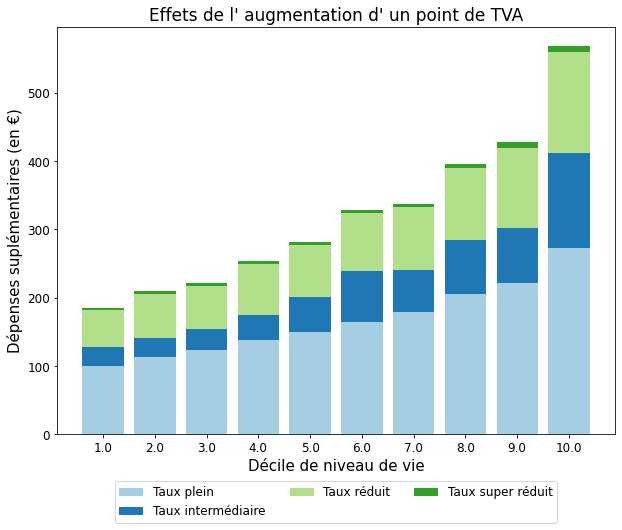

In [64]:
stacked_bar_plot(reforme_all, 
                 variables = ['depenses_tva_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effets de l\' augmentation d\' un point de TVA',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Dépenses suplémentaires (en €)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Effet_net_augmentation_TVA.pdf')

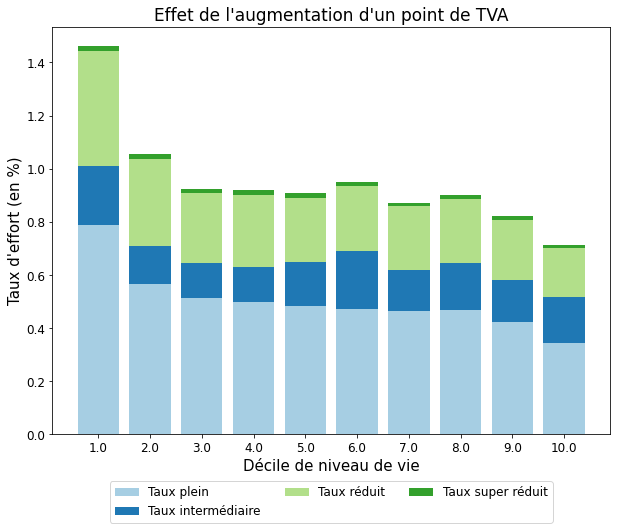

In [65]:
stacked_bar_plot(reforme_all, 
                 variables = ['Taux_effort_tva_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effet de l\'augmentation d\'un point de TVA',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Taux d\'effort (en %)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort.pdf')

In [1]:
from openfisca_france_indirect_taxation.variables.base import get_legislation_data_frames

In [ ]:
categories_fiscales_data_frame, codes_coicop_data_frame = get_legislation_data_frames()

In [4]:
categories_fiscales_data_frame.loc[categories_fiscales_data_frame['categorie_fiscale'] == 'tva_taux_intermediaire']

,code_bdf,categorie_fiscale,start,stop,label,Label,formatted_code_bdf,code_coicop
91,c04321,tva_taux_intermediaire,1994,2024,Services d'entretien et petites réparation dan...,Services d'entretien et petites réparation dan...,04.3.2.1,04.3.2.1
95,c04411,tva_taux_intermediaire,2012,2024,Redevance d’enlèvement des ordures,Enlèvement des ordures : Redevance ordures mén...,04.4.1.1,04.4.2.1
96,c04421,tva_taux_intermediaire,2012,2024,Services d’assainissement,Assainissement,04.4.2.1,04.4.3.1
105,c04541,tva_taux_intermediaire,2012,2024,Combustible solide résidence principale,Combustible solide résidence principale,04.5.4.1,04.5.4.1
142,c05621,tva_taux_intermediaire,1994,2024,"Services domestiques (ménage, garde enfant, ja...","Services domestiques (ménage, garde enfant, ja...",05.6.2.1,05.6.2.1
167,c07311,tva_taux_intermediaire,2012,2024,Services de transports de voyageurs locaux (mé...,Services de transports de voyageurs par chemin...,07.3.1.1,07.3.1.1
170,c07321,tva_taux_intermediaire,2012,2024,Services de transports de voyageurs par route ...,Services de transports de voyageurs par route ...,07.3.2.1,07.3.2.1
173,c07351,tva_taux_intermediaire,2012,2024,Services combinés de transport de voyageurs ca...,Services combinés de transport de voyageurs,07.3.5.1,07.3.5.1
175,c07341,tva_taux_intermediaire,2012,2024,Services de transport par mer et voies navigab...,Services de transport par mer et voies navigab...,07.3.4.1,07.3.4.1
200,c09411,tva_taux_intermediaire,2015,2024,Services sportifs et récréatifs (spectacles sp...,Services sportifs et récréatifs (spectacles sp...,09.4.1.1,09.4.2.2
